In [404]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [405]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

## 모델

### Positional Encodnig

In [406]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### Multi-Head Attention

In [407]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### Position-wise Feed-Forward Network

In [408]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### Encoder Layer

In [409]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

### Decoder Layer

In [410]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder

In [411]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder

In [412]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer

In [413]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### mask

In [414]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

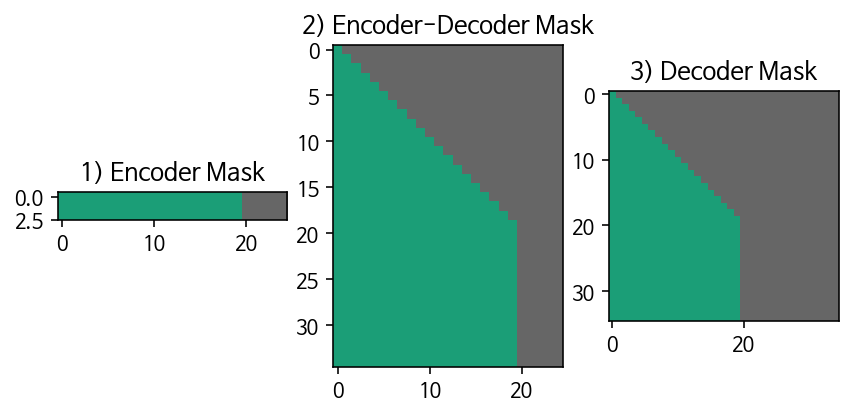

In [415]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### Optimizer & Learning Rate

In [416]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## 데이터 전처리

In [417]:
path = os.getenv("HOME") + "/aiffel/s2s_translation/korean-english-park."

In [418]:
ko_file = ["train.ko", "dev.ko", "test.ko"]
en_file = ["train.en", "dev.en", "test.en"]

In [419]:
enc_corpus = []
dec_corpus = []

In [420]:
for one_file in ko_file:
    with open(path+one_file, "r") as f:
        raw = f.read().splitlines()
        enc_corpus.extend(raw)

In [421]:
len(enc_corpus)

97123

In [422]:
for one_file in en_file:
    with open(path+one_file, "r") as f:
        raw = f.read().splitlines()
        dec_corpus.extend(raw)

In [423]:
len(dec_corpus)

97123

In [424]:
import pandas as pd
df = pd.DataFrame(enc_corpus, columns=['enc'])

In [425]:
df

,enc
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...
...,...
97118,코리아 헤럴드는 이번 관련법 개정으로 해외 부동산을 취득하고자 하는 개인에 대한 규...
97119,또한 투자 펀드를 통해 해외 부동산에 투자하고자 하는 사람들에게도 유리해지도록 법 ...
97120,"반 외교부장관, 최근 핵 문제 관련 북한 태도에 경고"
97121,"일본, 통근 열차 탈선 사고로 최소 69명 사망"


In [426]:
df['dec'] = dec_corpus

In [427]:
df.tail()

,enc,dec
97118,코리아 헤럴드는 이번 관련법 개정으로 해외 부동산을 취득하고자 하는 개인에 대한 규...,The Korea Herald reports part of these changes...
97119,또한 투자 펀드를 통해 해외 부동산에 투자하고자 하는 사람들에게도 유리해지도록 법 ...,Other legal changes will help those aiming to ...
97120,"반 외교부장관, 최근 핵 문제 관련 북한 태도에 경고",Foreign minister Ban warned North Korea for it...
97121,"일본, 통근 열차 탈선 사고로 최소 69명 사망",Japan's derailed commuter train accident has k...
97122,중국 공안경찰은 그간 세간의 이목을 끌었던 몇몇 소송을 제기해 온 저명한 인권 운동...,Communist Chinese police have detained a promi...


In [428]:
df[df.duplicated()]

,enc,dec
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
9925,*판매 제품,The goods
10070,* 알아두면 좋은 것:,Good to know:
10074,* 알아두면 좋은 것:,Good to know:
10079,* 알아두면 좋은 것:,Good to know:
...,...,...
95408,온도계가 없다면 어떻게 해야 할까?,No thermometer? Try this...
95414,온도계가 없다면 어떻게 해야 할까?,No thermometer? Try this...
95423,온도계가 없다면 어떻게 해야 할까?,No thermometer? Try this...
95428,주의를 기울어야 하는 이유,Why should you care?


In [429]:
df = df.drop_duplicates()

In [430]:
df

,enc,dec
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
97118,코리아 헤럴드는 이번 관련법 개정으로 해외 부동산을 취득하고자 하는 개인에 대한 규...,The Korea Herald reports part of these changes...
97119,또한 투자 펀드를 통해 해외 부동산에 투자하고자 하는 사람들에게도 유리해지도록 법 ...,Other legal changes will help those aiming to ...
97120,"반 외교부장관, 최근 핵 문제 관련 북한 태도에 경고",Foreign minister Ban warned North Korea for it...
97121,"일본, 통근 열차 탈선 사고로 최소 69명 사망",Japan's derailed commuter train accident has k...


In [431]:
import numpy as np
enc_corpus = list(np.array(df.enc.tolist()))
dec_corpus = list(np.array(df.dec.tolist()))

In [432]:
print(len(enc_corpus))
print(len(dec_corpus))

81959
81959


In [433]:
import re
def preprocess_sentence_kor(sentence):

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [434]:
def preprocess_sentence_eng(sentence, s_token=True, e_token=True):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [435]:
enc_corpus[0]

'개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'

In [436]:
enc_cleaned = list(map(lambda x: preprocess_sentence_kor(x), enc_corpus))

In [437]:
enc_cleaned[0]

'개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?'

In [438]:
dec_corpus[0]

'Much of personal computing is about "can you top this?"'

In [439]:
dec_cleaned = list(map(lambda x: preprocess_sentence_eng(x), dec_corpus))

In [440]:
dec_cleaned[0]

'much of personal computing is about can you top this ?'

### SentencePiece Tokenizer - Kor

In [441]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/transformer/korean-english-park.train.ko.temp'

vocab_size = 20000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

with open(temp_file, 'w') as f:
    for row in enc_cleaned:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --pad_id={} --bos_id={} --eos_id={} --unk_id={} --model_prefix=korean_spm --vocab_size={}  --model_type=bpe'.format(temp_file, pad_id, bos_id, eos_id, unk_id, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel0035 aiffel0035 621036 12월  7 16:45 korean_spm.model
-rw-r--r-- 1 aiffel0035 aiffel0035 352238 12월  7 16:45 korean_spm.vocab


In [442]:
src_tokenizer = spm.SentencePieceProcessor()
src_tokenizer.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = src_tokenizer.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(src_tokenizer.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(src_tokenizer.DecodeIds(tokensIDs))

[6287, 6202, 18859, 1546, 18919, 18835, 18837]
['▁아버지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


In [443]:
with open('./korean_spm.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
word2idx = {w[0]: i for i, w in enumerate(Vo)}

In [444]:
dict(list(word2idx.items())[0:10])

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '▁.': 4,
 '▁이': 5,
 '했다': 6,
 '▁대': 7,
 '▁있': 8,
 '에서': 9}

텍스트의 최소 길이 : 0
텍스트의 최대 길이 : 64
텍스트의 평균 길이 : 16.022023206725315


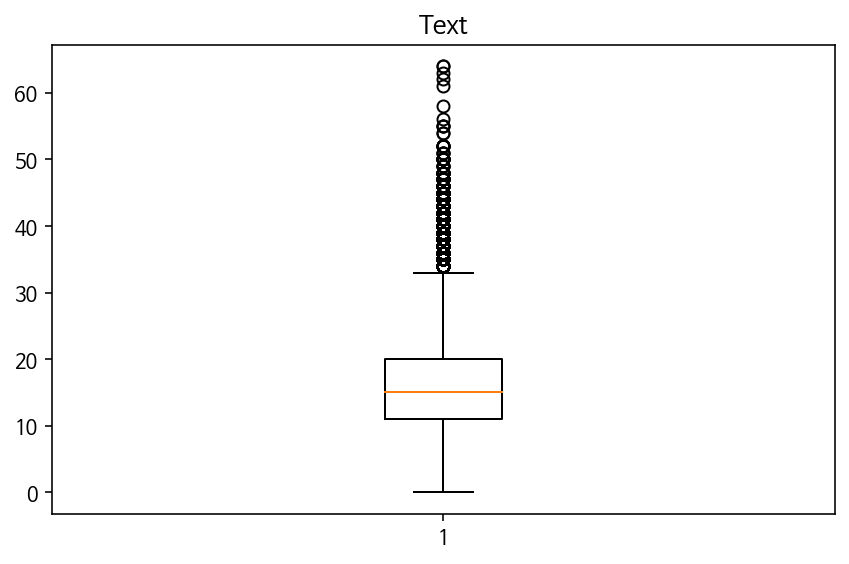

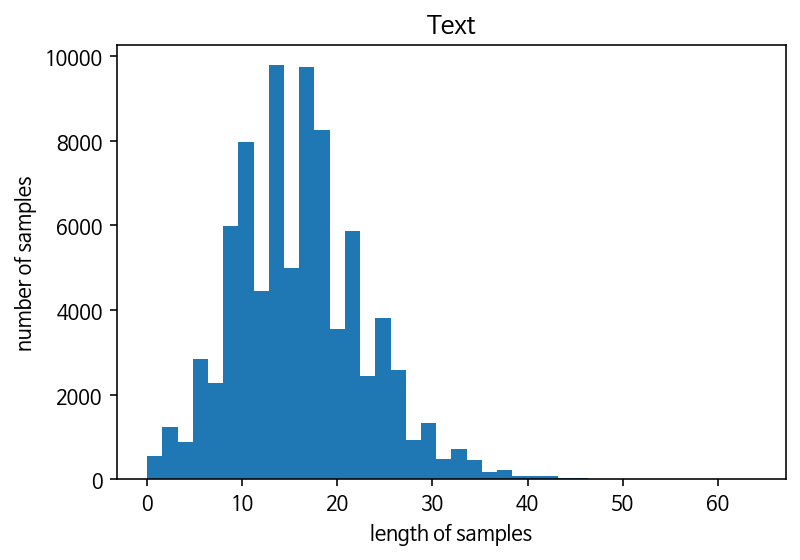

In [445]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in enc_cleaned]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,1,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [446]:
kor_encoding = []
for e in enc_cleaned:
    kor_encoding.append(src_tokenizer.EncodeAsIds(e))

In [447]:
kor_encoding[1]

[439,
 598,
 18893,
 18917,
 1435,
 4845,
 144,
 5,
 598,
 18893,
 4720,
 18869,
 740,
 18881,
 2724,
 1070,
 18838,
 70,
 4720,
 631,
 1951,
 6894,
 923,
 1202,
 4]

In [448]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
kor_padded = pad_sequences(kor_encoding, padding = 'post', maxlen=40)

In [449]:
len(kor_encoding)

81959

In [450]:
kor_padded

array([[ 1406, 18953,  1030, ...,     0,     0,     0],
       [  439,   598, 18893, ...,     0,     0,     0],
       [  187,  2482,   373, ...,     0,     0,     0],
       ...,
       [  123,  4047,  2817, ...,     0,     0,     0],
       [  255,    10,  8803, ...,     0,     0,     0],
       [  176, 11157,  3366, ...,     0,     0,     0]], dtype=int32)

In [451]:
enc_tensor=kor_padded

In [452]:
enc_tensor

array([[ 1406, 18953,  1030, ...,     0,     0,     0],
       [  439,   598, 18893, ...,     0,     0,     0],
       [  187,  2482,   373, ...,     0,     0,     0],
       ...,
       [  123,  4047,  2817, ...,     0,     0,     0],
       [  255,    10,  8803, ...,     0,     0,     0],
       [  176, 11157,  3366, ...,     0,     0,     0]], dtype=int32)

### SentencePiece Tokenizer - Eng

In [453]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/transformer/korean-english-park.train.en.temp'

vocab_size = 20000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

with open(temp_file, 'w') as f:
    for row in dec_cleaned:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --pad_id={} --bos_id={} --eos_id={} --unk_id={} --model_prefix=english_spm --vocab_size={}  --model_type=bpe'.format(temp_file, pad_id, bos_id, eos_id, unk_id, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l english_spm*

-rw-r--r-- 1 aiffel0035 aiffel0035 585542 12월  7 16:46 english_spm.model
-rw-r--r-- 1 aiffel0035 aiffel0035 316743 12월  7 16:46 english_spm.vocab


In [454]:
tgt_tokenizer = spm.SentencePieceProcessor()
tgt_tokenizer.Load('english_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = tgt_tokenizer.EncodeAsIds('Hi nice to meet you.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(tgt_tokenizer.SampleEncodeAsPieces('Hi nice to meet you.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(tgt_tokenizer.DecodeIds(tokensIDs))

[19971, 3, 19975, 7181, 33, 670, 457, 19992]
['▁', 'H', 'i', '▁nice', '▁to', '▁meet', '▁you', '.']
 ⁇ i nice to meet you.


In [455]:
with open('./english_spm.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
word2idx_eng = {w[0]: i for i, w in enumerate(Vo)}

In [456]:
dict(list(word2idx_eng.items())[0:11])

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '▁t': 4,
 '▁a': 5,
 'he': 6,
 'in': 7,
 '▁s': 8,
 '▁the': 9,
 're': 10}

텍스트의 최소 길이 : 0
텍스트의 최대 길이 : 99
텍스트의 평균 길이 : 24.788040361644235


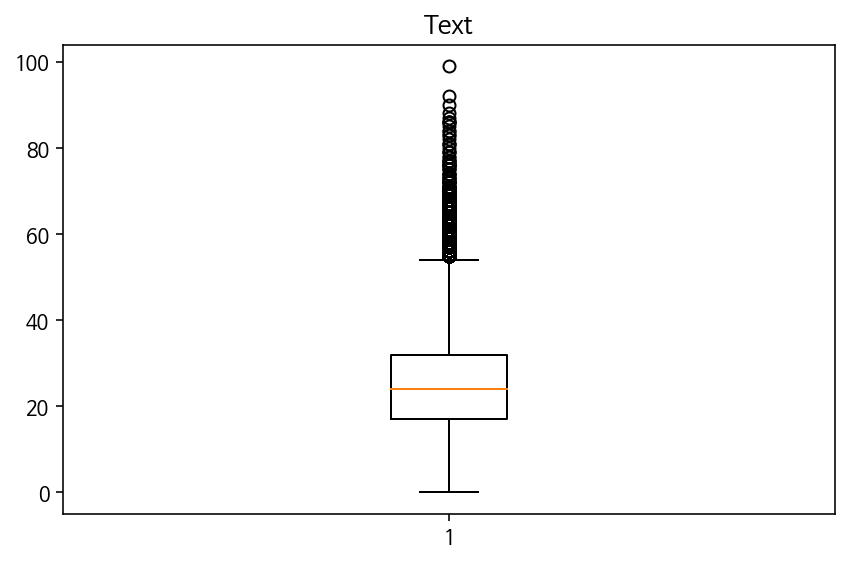

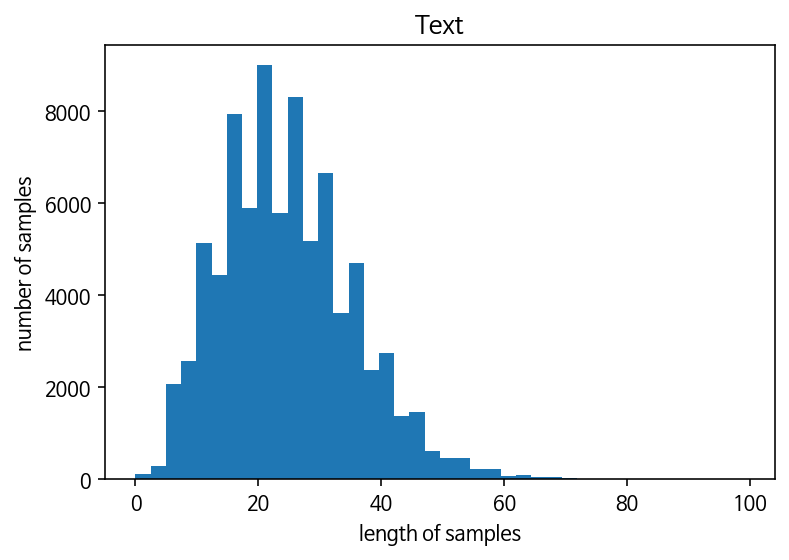

In [457]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in dec_cleaned]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,1,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [458]:
tgt_tokenizer.set_encode_extra_options("bos:eos")

True

In [459]:
eng_encoding = []
for e in dec_cleaned:
    eng_encoding.append(tgt_tokenizer.EncodeAsIds(e))

In [460]:
eng_padded = pad_sequences(eng_encoding, padding = 'post', maxlen=40)

In [461]:
dec_tensor=eng_padded

In [462]:
dec_tensor[0]

array([    1,  1102,    37,  2977, 13769,    81,   250,   347,   457,
         826,   235, 19971,     3,     2,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [463]:
enc_train = enc_tensor
dec_train = dec_tensor

## 훈련하기

### 트랜스포머 모델 선언

In [464]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = Transformer(
    d_model=D_MODEL,
    n_heads=NUM_HEADS,
    n_layers=NUM_LAYERS,
    d_ff=UNITS,
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    pos_len=200)

### Learning Rate Scheduler, Adam Optimizer 선언

In [465]:
learning_rate = LearningRateScheduler(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### Loss 함수 선언 (Masking 되지 않은 입력의 개수로 Scaling)

In [466]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 입력 데이터에 알맞은 Mask 생성

### 매 Epoch마다 제시된 예문에 대한 번역을 생성

In [467]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [468]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [469]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [470]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [471]:
sentences = ['오바마는 대통령이다', '시민들이 도시 속에 산다.', '커피는 필요없다.', '일곱명의 사망자가 발생했다.']

In [472]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    model,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    print('Translations' )
    for sentence in sentences:
        translate(sentence, model,src_tokenizer, tgt_tokenizer)
    print()
    print('Hyperparameters' )
    print('n_layers :', N_LAYERS)
    print('d_model :', D_MODEL)
    print('n_heads : ', N_HEADS)
    print('d_ff :', D_FF)
    print('dropout :', DROPOUT)
    print()
    print('TRAINING')
    print('Warmup Steps: 4000')
    print('Batch size : 64')
    print('Epoch At : ', epoch+1)

/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


ValueError: in user code:

    <ipython-input-393-6068d0454f95>:9 train_step  *
        predictions, enc_attns, dec_attns, dec_enc_attns =         model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
    <ipython-input-71-73ec5f30979b>:48 call  *
        dec_out, dec_attns, dec_enc_attns =         self.decoder(dec_in, enc_out, causality_mask, dec_mask)
    <ipython-input-70-0ef3ee6d2dd9>:20 call  *
        out, dec_attn, dec_enc_attn =             self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
    <ipython-input-68-62944f3df52a>:23 call  *
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
    <ipython-input-65-8bccadd0b576>:53 call  *
        out, attention_weights = self.scaled_dot_product_attention(
    <ipython-input-65-8bccadd0b576>:21 scaled_dot_product_attention  *
        if mask is not None: scaled_qk += (mask * -1e9)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1276 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:483 add_v2
        "AddV2", x=x, y=y, name=name)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /home/aiffel0035/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 39 and 40 for '{{node transformer_8/decoder_8/decoder_layer_16/multi_head_attention_50/add}} = AddV2[T=DT_FLOAT](transformer_8/decoder_8/decoder_layer_16/multi_head_attention_50/truediv, transformer_8/decoder_8/decoder_layer_16/multi_head_attention_50/mul)' with input shapes: [64,8,39,39], [64,1,39,40].
